In [2]:
import torch
import hypernetx as hnx
import networkx as nx

from functools import partial

# from models.hypergraph_models import HyperGCN
from models.hypergraph_models import MyHyperGCN

from hgraph.random_hgraph import generate_random_uniform_hypergraph, generate_random_hypergraph
from hgraph.motif import attach_houses_to_incidence_dict
from load_coraca import incidence_matrix_to_edge_index

from train_utils import train_eval_loop, get_activations, get_train_val_test_mask

from vis_utils import plot_activations_by_class, plot_cluster_activations
from graph_utils import plot_samples

# test `generate_random_hypergraph`

(10, 10)
(10, 10)
(10, 10)
{'e0000': [3, 6, 7], 'e0001': [1, 2], 'e0002': [6], 'e0003': [6], 'e0004': [0, 4, 7], 'e0005': [1, 3, 5, 8], 'e0006': [7, 8, 9], 'e0007': [1, 2, 4, 6, 7], 'e0008': [0, 1, 4, 5, 8], 'e0009': [0, 5, 7]}


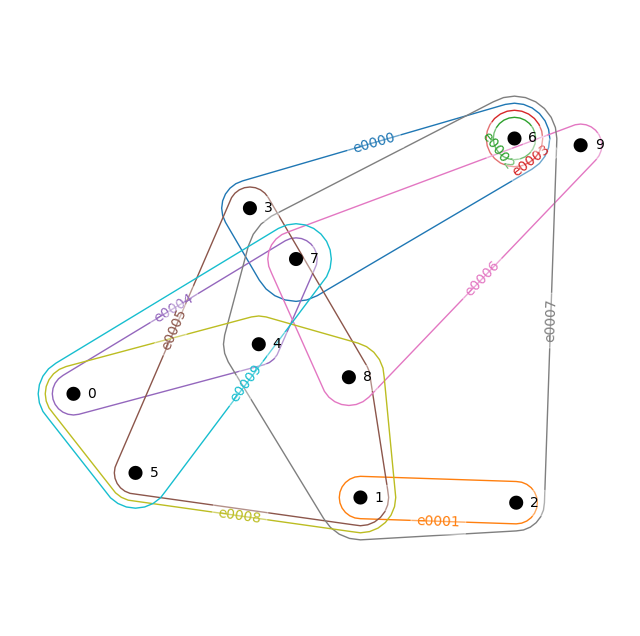

In [3]:
h_base = generate_random_hypergraph(num_nodes=10, num_edges=10)
print(h_base.shape)
print(h_base.incidence_dict)
hnx.draw(h_base)

In [4]:
num_nodes = 5
num_edges = 2
k = 3

h_base = generate_random_uniform_hypergraph(num_nodes, num_edges, k)

incdict_deco, labels = attach_houses_to_incidence_dict([0, 1, 2], h_base.incidence_dict, h_base.number_of_nodes(), h_base.number_of_edges())

h_deco = hnx.Hypergraph(incdict_deco)

In [5]:
print(h_base.incidence_dict)
print(h_deco.incidence_dict)
print(labels)

{'e0000': [1, 2, 3], 'e0001': [0, 1, 3]}
{'e0000': [1, 2, 3], 'e0001': [0, 1, 3], 'e0002': [0, 4, 5], 'e0003': [0, 5, 6, 7], 'e0004': [0, 4, 5, 6, 7], 'e0005': [1, 8, 9], 'e0006': [1, 9, 10, 11], 'e0007': [1, 8, 9, 10, 11], 'e0008': [2, 12, 13], 'e0009': [2, 13, 14, 15], 'e0010': [2, 12, 13, 14, 15]}
tensor([2, 2, 2, 0, 1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3])


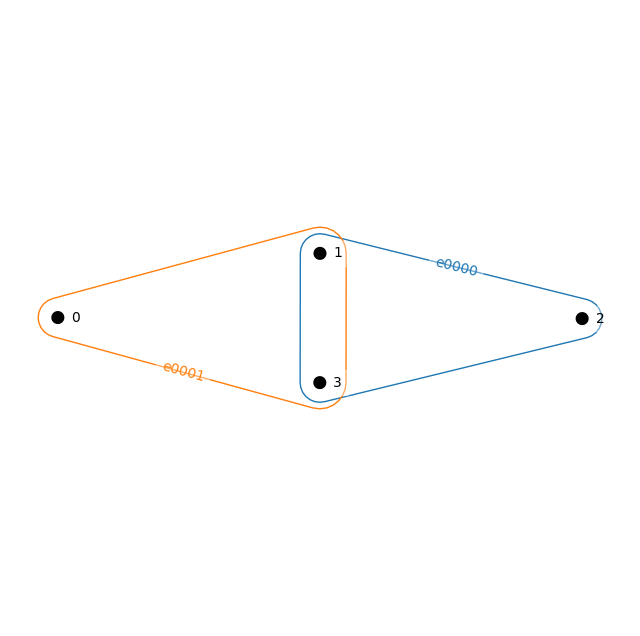

In [6]:
hnx.draw(h_base, layout=partial(nx.spring_layout, seed=0))

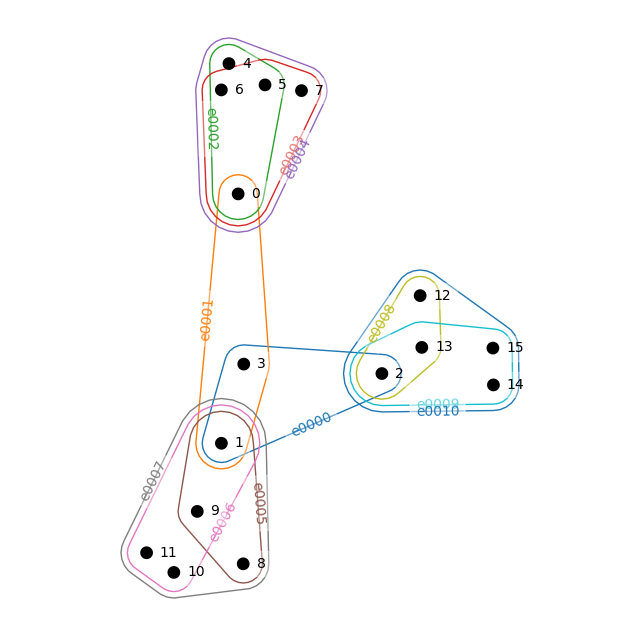

In [7]:
hnx.draw(h_deco, layout=partial(nx.spring_layout, seed=0))

# random hgraph

In [5]:
num_nodes = 400
num_edges = 200
k = 3
num_houses = 100

# h_base = generate_random_uniform_hypergraph(num_nodes, num_edges, k) # k-uniform hypergraph
h_base = generate_random_hypergraph(num_nodes, num_edges) # random hypergraph from random bipartite graph

# anchor_nodes = torch.randint(low=0, high=h_base.number_of_nodes(), size=(num_houses,)).tolist()
anchor_nodes = range(num_houses)
incmat_deco, labels_deco = attach_houses_to_incidence_dict(anchor_nodes, h_base.incidence_dict, h_base.number_of_nodes(), h_base.number_of_edges())
h_deco = hnx.Hypergraph(incmat_deco)

print(f"{h_base.number_of_nodes()=}, {h_base.number_of_edges()=}")
print(f"{h_deco.number_of_nodes()=}, {h_deco.number_of_edges()=}")

(309, 192)
(309, 192)
h_base.number_of_nodes()=309, h_base.number_of_edges()=192
h_deco.number_of_nodes()=709, h_deco.number_of_edges()=492


In [6]:
print(len(labels_deco))
print(sum(labels_deco == 0).item())
print(sum(labels_deco == 1).item())
print(sum(labels_deco == 2).item())
print(sum(labels_deco == 3).item())

709
209
100
200
200


In [7]:
hgraph = h_deco

train_mask, val_mask, test_mask = get_train_val_test_mask(n=hgraph.number_of_nodes(), split=[0.8, 0.2, 0.0], seed=3)
hgraph.train_mask = train_mask
hgraph.val_mask = val_mask
hgraph.test_mask = test_mask

hgraph.x = torch.zeros((hgraph.number_of_nodes(), 1), dtype=torch.float32)
# hgraph.x = torch.ones((hgraph.number_of_nodes(), 1), dtype=torch.float32)
# hgraph.x = torch.randn((hgraph.number_of_nodes(), 1), dtype=torch.float32)

hgraph.y = labels_deco
hgraph.H = torch.tensor(hgraph.incidence_matrix().toarray())
hgraph.edge_index = incidence_matrix_to_edge_index(hgraph.H)

/home/ss3072/venv_geo/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


# run hgnn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def put_hgraph_attributes_on_device(hgraph, device) -> None:
    hgraph.train_mask = hgraph.train_mask.to(device)
    hgraph.val_mask = hgraph.val_mask.to(device)
    hgraph.test_mask = hgraph.test_mask.to(device)
    hgraph.x = hgraph.x.to(device)
    hgraph.y = hgraph.y.to(device)
    hgraph.H = hgraph.H.to(device)
    hgraph.edge_index = hgraph.edge_index.to(device)

In [8]:
model_gcn = MyHyperGCN(input_dim=1, hidden_dim=16, output_dim=4, num_layers=3, symmetric_norm=False, bias=True, use_attention=False)
model_gcn.to(device)

put_hgraph_attributes_on_device(hgraph, device)

train_stats = train_eval_loop(
    model=model_gcn,
    hgraph=hgraph,
    train_mask=hgraph.train_mask,
    val_mask=hgraph.val_mask,
    test_mask=hgraph.test_mask,
    lr=0.001,
    num_epochs=5000,
    printevery=500,
)

Epoch 500 with train loss: 1.231 train acc: 0.419 val acc: 0.454
Epoch 1000 with train loss: 1.092 train acc: 0.713 val acc: 0.709
Epoch 1500 with train loss: 0.924 train acc: 0.697 val acc: 0.709
Epoch 2000 with train loss: 0.800 train acc: 0.732 val acc: 0.738
Epoch 2500 with train loss: 0.709 train acc: 0.776 val acc: 0.773
Epoch 3000 with train loss: 0.647 train acc: 0.805 val acc: 0.809
Epoch 3500 with train loss: 0.600 train acc: 0.806 val acc: 0.801
Epoch 4000 with train loss: 0.540 train acc: 0.806 val acc: 0.823
Epoch 4500 with train loss: 0.503 train acc: 0.808 val acc: 0.823
Epoch 5000 with train loss: 0.464 train acc: 0.898 val acc: 0.908
Final train acc: 0.898 | val acc: 0.908 | test acc: nan 


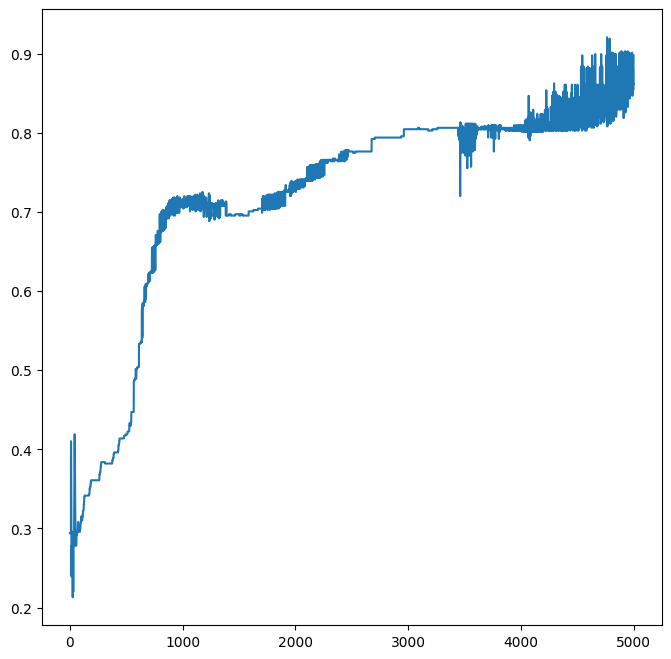

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_stats['epoch'], train_stats['train_acc'])

In [11]:
model_gcn.eval()
with torch.no_grad():
    out = model_gcn(hgraph)

In [13]:
def acc_details(logits, labels):

    tot = len(labels)

    print("random guessing")
    print(f"0 {sum(labels_deco == 0).item() / tot : .2f}")
    print(f"1 {sum(labels_deco == 1).item() / tot : .2f}")
    print(f"2 {sum(labels_deco == 2).item() / tot : .2f}")
    print(f"3 {sum(labels_deco == 3).item() / tot : .2f}")

    print("distribution of outs")
    preds = logits.argmax(dim=-1)
    print(f"0 {sum(preds == 0).item() / tot : .2f}")
    print(f"1 {sum(preds == 1).item() / tot : .2f}")
    print(f"2 {sum(preds == 2).item() / tot : .2f}")
    print(f"3 {sum(preds == 3).item() / tot : .2f}")

    match = preds == labels
    print("achieved accs")
    print(f"0 {sum(match[labels == 0]).item() / sum(labels_deco == 0).item() : .2f}")
    print(f"1 {sum(match[labels == 1]).item() / sum(labels_deco == 1).item() : .2f}")
    print(f"2 {sum(match[labels == 2]).item() / sum(labels_deco == 2).item() : .2f}")
    print(f"3 {sum(match[labels == 3]).item() / sum(labels_deco == 3).item() : .2f}")
    print(f"all {sum(match).item() / tot : .2f}")

In [14]:
acc_details(out, hgraph.y)

random guessing
0  0.29
1  0.14
2  0.28
3  0.28
distribution of outs
0  0.28
1  0.10
2  0.30
3  0.32
achieved accs
0  0.87
1  0.67
2  0.96
3  0.99
all  0.90


# activations

In [15]:
model_gcn

MyHyperGCN(
  (gcn_layers): ModuleList(
    (0): MyHypergraphConv(
      (Linear): Linear(in_features=1, out_features=16, bias=True)
    )
    (1): MyHypergraphConv(
      (Linear): Linear(in_features=16, out_features=16, bias=True)
    )
    (2): MyHypergraphConv(
      (Linear): Linear(in_features=16, out_features=4, bias=True)
    )
  )
  (drop): Dropout(p=0, inplace=False)
)

In [16]:
activations_gcn = {}

model_gcn.gcn_layers[0].register_forward_hook(get_activations('conv0', activations_gcn))
model_gcn.gcn_layers[1].register_forward_hook(get_activations('conv1', activations_gcn))
model_gcn.gcn_layers[2].register_forward_hook(get_activations('conv2', activations_gcn))

In [17]:
model_gcn.eval()
with torch.no_grad():
    out = model_gcn(hgraph)

/home/ss3072/venv_geo/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


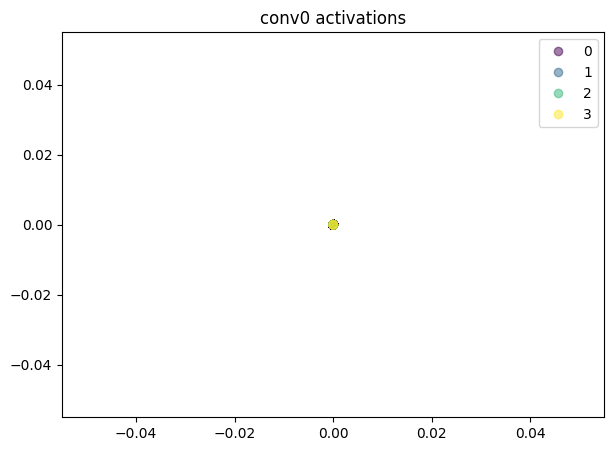

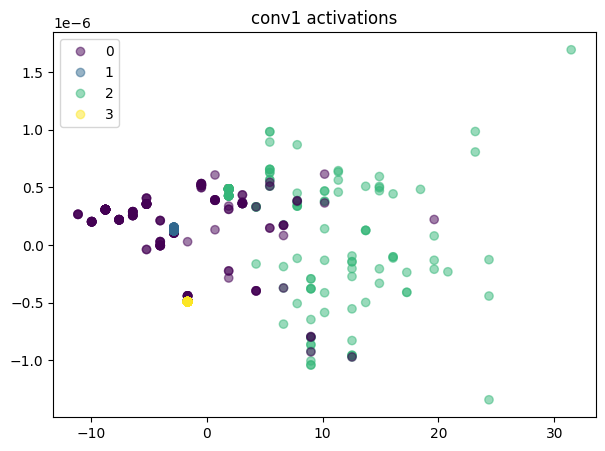

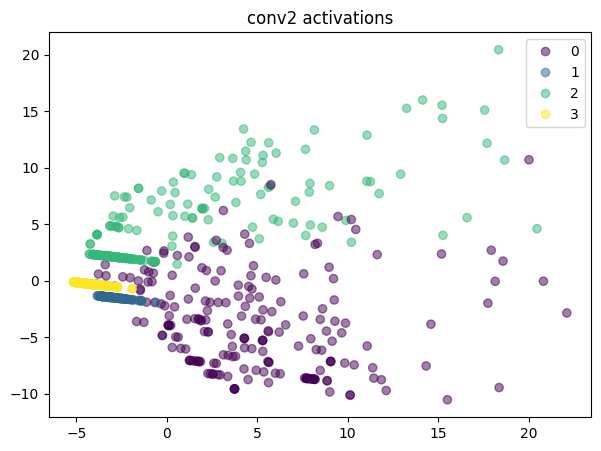

In [18]:
plot_activations_by_class(activations_gcn, hgraph.y)

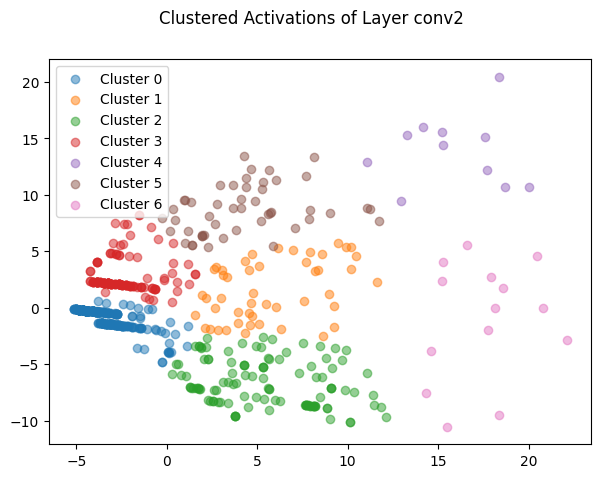

In [19]:
activ_gcn, kmeans_model_gcn = plot_cluster_activations(activations_gcn, 'conv2', num_clusters=7)

# concepts

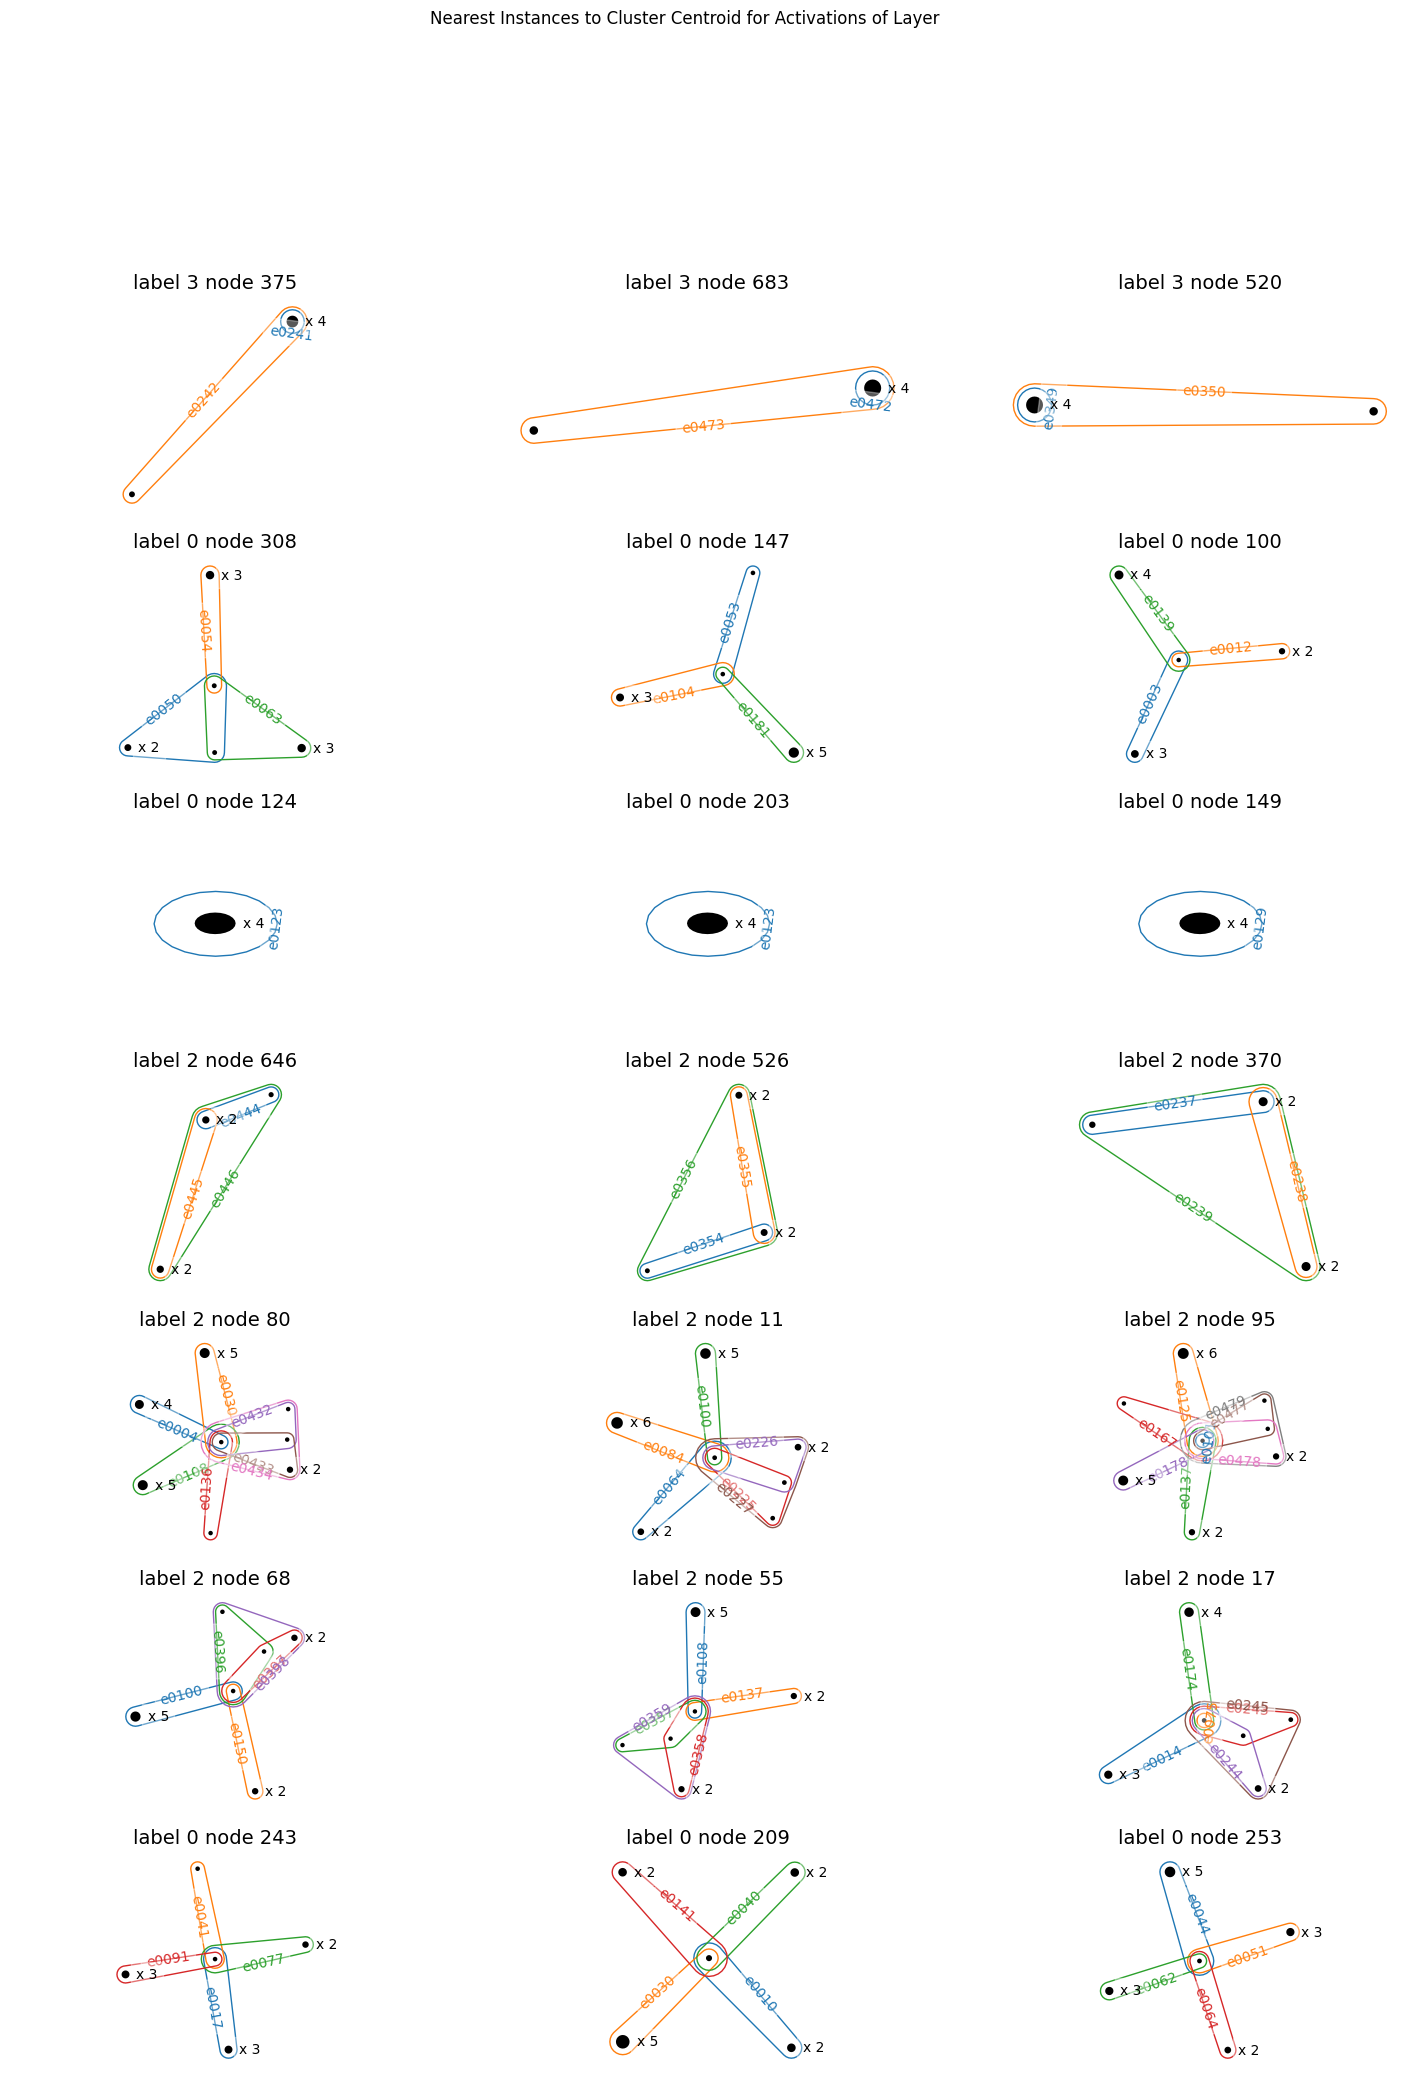

In [20]:
sample_graphs, sample_feats = plot_samples(activ_gcn, kmeans_model_gcn, hgraph.y, hgraph, num_expansions=1, num_nodes_view=3)